In [1]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [2]:
df=pd.read_csv('data/output.csv')

In [3]:
df.columns

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged'],
      dtype='object')

In [4]:
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged
0,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01 13:38:27,50000.0,2016-02-26 13:38:27,52375.0,successful,224.0,US,52375.0
1,1000023410,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21 18:30:44,1000.0,2014-12-01 18:30:44,1205.0,successful,16.0,US,1205.0
2,100005484,Lisa Lim New CD!,Indie Rock,Music,USD,2013-04-08 06:42:58,12500.0,2013-03-09 06:42:58,12700.0,successful,100.0,US,12700.0
3,1000070642,Mike Corey's Darkness & Light Album,Music,Music,USD,2012-08-17 14:11:32,250.0,2012-08-02 14:11:32,250.0,successful,7.0,US,250.0
4,1000072011,CMUK. Shoes: Take on Life Feet First.,Fashion,Fashion,USD,2013-12-30 07:06:11,20000.0,2013-11-25 07:06:11,34268.0,successful,624.0,US,34268.0


In [5]:
df.isnull().sum()

ID               0
name             3
category         0
main_category    0
currency         0
deadline         0
goal             0
launched         0
pledged          0
state            0
backers          0
country          0
usd pledged      0
dtype: int64

In [6]:
# First, some data cleaning & preprocessing

# ! 1 - Drop the ID and name columns
df.drop(['ID', 'name', 'usd pledged'], axis=1, inplace=True)

# ! 2 - Drop any rows that have NaN values
df.dropna(inplace=True)

# ! 3 - Calculate the campaign duration in days as the difference between the deadline and launched columns
# ! then drop the deadline and launched columns
df['deadline'] = pd.to_datetime(df['deadline'])
df['launched'] = pd.to_datetime(df['launched'])
df['duration'] = (df['deadline'] - df['launched']).dt.days
df.drop(['deadline', 'launched'], axis=1, inplace=True)

# ! 4 - convert all strings to lowercase
df['category'] = df['category'].str.lower()
df['main_category'] = df['main_category'].str.lower()
df['currency'] = df['currency'].str.lower()

In [7]:
df.head()

,category,main_category,currency,goal,pledged,state,backers,country,duration
0,restaurants,food,usd,50000.0,52375.0,successful,224.0,US,35
1,food,food,usd,1000.0,1205.0,successful,16.0,US,20
2,indie rock,music,usd,12500.0,12700.0,successful,100.0,US,30
3,music,music,usd,250.0,250.0,successful,7.0,US,15
4,fashion,fashion,usd,20000.0,34268.0,successful,624.0,US,35


In [8]:
# One last prepcrocessing step: For any column with continuous values, convert the values to discrete values
# Using KMeans clustering with variable k
# How the value of k for every column is determined using the elbow method

# ! The following columns have continuous values:
# ! usd pledged, backers, duration, usd goal

In [9]:
df_continue = df.copy(deep=True)

In [10]:
km = KMeans(init='random', n_init=10, random_state=0)
k_range = range(2, 11)
visualizer_wss = KElbowVisualizer(km, k=k_range, metric='distortion')

backers_k = 5


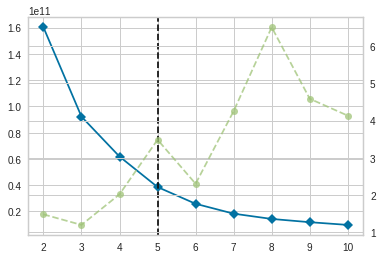

In [11]:
# Fit the visualizer to the backers column and show the plot
visualizer_wss.fit(df['backers'].values.reshape(-1, 1))
backers_k = visualizer_wss.elbow_value_
print('backers_k =', backers_k)

In [11]:
# Fit the visualizer to the pledged column and show the plot
visualizer_wss.fit(df['pledged'].values.reshape(-1, 1))
pledged_k = visualizer_wss.elbow_value_
print('pledged_k =', pledged_k)

pledged_k = 4


In [12]:
# Fit the visualizer to the used goal column and show the plot
visualizer_wss.fit(df['goal'].values.reshape(-1, 1))
goal_k = visualizer_wss.elbow_value_
print('goal_k =', goal_k)

goal_k = 4


In [13]:
# Fit the visualizer to the duration column and show the plot
visualizer_wss.fit(df['duration'].values.reshape(-1, 1))
duration_k = visualizer_wss.elbow_value_
visualizer_wss.show()
print('duration_k =', duration_k)

duration_k = 5


In [14]:
# Show the range of values for each column after discretization
print('backers range =', df['backers'].max() - df['backers'].min())
print('pledged range =', df['pledged'].max() - df['pledged'].min())
print('goal range =', df['goal'].max() - df['goal'].min())
print('duration range =', df['duration'].max() - df['duration'].min())

backers range = 219382.0
pledged range = 20338986.27
goal range = 99999999.99
duration range = 92


In [15]:
# Show the minimum and maximum value in each cluster for each column
# This is to determine the range of values for each cluster

# ! backers
km = KMeans(n_clusters=backers_k, init='random', n_init=10, random_state=0)
km.fit(df['backers'].values.reshape(-1, 1))
df['backers_cluster'] = km.predict(df['backers'].values.reshape(-1, 1))
# Reorder the clusters according to the minimum values
min_df = df.groupby('backers_cluster')['backers'].agg(['min']).sort_values(by='min').reset_index()
label_dict = {row['backers_cluster']: index for index, row in min_df.iterrows()}
df['backers_cluster'] = df['backers_cluster'].map(label_dict)
df.groupby('backers_cluster')['backers'].agg(['min', 'max', 'count']).sort_values(by='min')

,min,max,count
backers_cluster,,,
0,0.0,2102.0,331935
1,2103.0,11169.0,2280
2,11281.0,41733.0,184
3,42713.0,105857.0,24
4,154926.0,219382.0,2


In [16]:
#
# ! pledged
km = KMeans(n_clusters=pledged_k, init='random', n_init=10, random_state=0)
km.fit(df['pledged'].values.reshape(-1, 1))
df['pledged_cluster'] = km.predict(df['pledged'].values.reshape(-1, 1))
# Reorder the clusters according to the minimum values
min_df = df.groupby('pledged_cluster')['pledged'].agg(['min']).sort_values(by='min').reset_index()
label_dict = {row['pledged_cluster']: index for index, row in min_df.iterrows()}
df['pledged_cluster'] = df['pledged_cluster'].map(label_dict)
df.groupby('pledged_cluster')['pledged'].agg(['min', 'max', 'count']).sort_values(by='min')

,min,max,count
pledged_cluster,,,
0,0.00,368630.01,333228
1,368841.00,1960430.00,1083
2,2032434.63,7072757.00,105
3,8596474.58,20338986.27,9


In [17]:
#
# ! goal
km = KMeans(n_clusters=goal_k, init='random', n_init=10, random_state=0)
km.fit(df['goal'].values.reshape(-1, 1))
df['goal_cluster'] = km.predict(df['goal'].values.reshape(-1, 1))
# Reorder the clusters according to the minimum values
min_df = df.groupby('goal_cluster')['goal'].agg(['min']).sort_values(by='min').reset_index()
label_dict = {row['goal_cluster']: index for index, row in min_df.iterrows()}
df['goal_cluster'] = df['goal_cluster'].map(label_dict)
df.groupby('goal_cluster')['goal'].agg(['min', 'max', 'count']).sort_values(by='min')

,min,max,count
goal_cluster,,,
0,0.01,4500000.0,334129
1,4845000.00,22500000.0,222
2,25000000.00,60000000.0,40
3,70000000.00,100000000.0,34


In [18]:
#
# ! duration
km = KMeans(n_clusters=duration_k, init='random', n_init=10, random_state=0)
km.fit(df['duration'].values.reshape(-1, 1))
df['duration_cluster'] = km.predict(df['duration'].values.reshape(-1, 1))
# Reorder the clusters according to the minimum values
min_df = df.groupby('duration_cluster')['duration'].agg(['min']).sort_values(by='min').reset_index()
label_dict = {row['duration_cluster']: index for index, row in min_df.iterrows()}
df['duration_cluster'] = df['duration_cluster'].map(label_dict)
# Show the minimum and maximum values as well as number of rows in each cluster for each column
df.groupby('duration_cluster')['duration'].agg(['min', 'max', 'count']).sort_values(by='min')

,min,max,count
duration_cluster,,,
0,0,22,39135
1,23,36,213696
2,37,51,42637
3,52,73,35990
4,74,92,2967


In [19]:
# It's clear that the for the goal, pledged & backers columns, the clusters are not very useful because of 
# the large range of values in each cluster. Therefore, we will not use them in the model 
# could think of them as outliers

# I'll be removing the outliers from the goal, pledged & backers columns

# ? (Pretty much only the values in cluster 0 will be kept, this is for all 3 columns)
# Get the indices of the rows with backers values not in cluster 0
indices = df[df['backers_cluster'] != 0].index
# Drop the rows with the indices
df.drop(indices, inplace=True)

# Get the indices of the rows with pledged values not in cluster 0
indices = df[df['pledged_cluster'] != 0].index
# Drop the rows with the indices
df.drop(indices, inplace=True)

# Get the indices of the rows with goal values not in cluster 0
indices = df[df['goal_cluster'] != 0].index
# Drop the rows with the indices
df.drop(indices, inplace=True)

# Drop the clusters columns
df.drop(['backers_cluster', 'pledged_cluster', 'goal_cluster'], axis=1, inplace=True)

backers_k = 3
pledged_k = 3
goal_k = 3


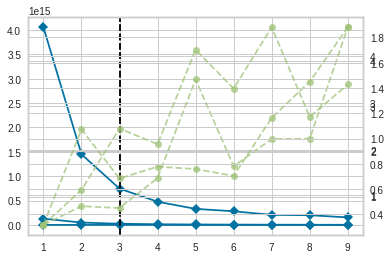

In [20]:
# Now reapply the elbow method to the like we did before

# Instantiate the clustering model and visualizer
visualizer_wss = KElbowVisualizer(KMeans(init='random', n_init=10, random_state=0), k=(1, 10))

# Fit the visualizer to the backers column and show the plot
visualizer_wss.fit(df['backers'].values.reshape(-1, 1))
backers_k = visualizer_wss.elbow_value_
print('backers_k =', backers_k)

# Fit the visualizer to the pledged column and show the plot
visualizer_wss.fit(df['pledged'].values.reshape(-1, 1))
pledged_k = visualizer_wss.elbow_value_
print('pledged_k =', pledged_k)

# Fit the visualizer to the goal column and show the plot
visualizer_wss.fit(df['goal'].values.reshape(-1, 1))
goal_k = visualizer_wss.elbow_value_
print('goal_k =', goal_k)

In [22]:
# apply KMeans to the to the backers, pledged & goal columns
km = KMeans(n_clusters=backers_k, init='random', n_init=10, random_state=0)
km.fit(df['backers'].values.reshape(-1, 1))
df['backers_cluster'] = km.predict(df['backers'].values.reshape(-1, 1))
df.groupby('backers_cluster')['backers'].agg(['min', 'max', 'count']).sort_values(by='min')

,min,max,count
backers_cluster,,,
0,0.0,212.0,304426
1,213.0,838.0,22034
2,839.0,2102.0,4819


In [23]:
km = KMeans(n_clusters=pledged_k, init='random', n_init=10, random_state=0)
km.fit(df['pledged'].values.reshape(-1, 1))
df['pledged_cluster'] = km.predict(df['pledged'].values.reshape(-1, 1))
df.groupby('pledged_cluster')['pledged'].agg(['min', 'max', 'count']).sort_values(by='min')

,min,max,count
pledged_cluster,,,
0,0.0,28505.00,314747
2,28510.0,125154.24,14664
1,125171.0,368630.01,1868


In [24]:
km = KMeans(n_clusters=goal_k, init='random', n_init=10, random_state=0)
km.fit(df['goal'].values.reshape(-1, 1))
df['goal_cluster'] = km.predict(df['goal'].values.reshape(-1, 1))
df.groupby('goal_cluster')['goal'].agg(['min', 'max', 'count']).sort_values(by='min')

,min,max,count
goal_cluster,,,
0,0.01,244000.0,326772
1,245000.00,1382000.0,4028
2,1397250.00,4500000.0,479


backers_k = 3
pledged_k = 3
goal_k = 3


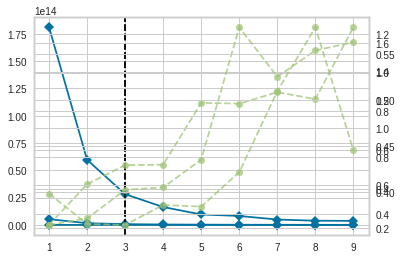

In [25]:
# Clearly, the clusters are still not very useful, so we will apply one more round of the elbow method
indices = df[df['backers_cluster'] != 0].index
# Drop the rows with the indices
df.drop(indices, inplace=True)

# Get the indices of the rows with pledged values not in cluster 0
indices = df[df['pledged_cluster'] != 0].index
# Drop the rows with the indices
df.drop(indices, inplace=True)

# Get the indices of the rows with goal values not in cluster 0
indices = df[df['goal_cluster'] != 0].index
# Drop the rows with the indices
df.drop(indices, inplace=True)

# Drop the clusters columns
df.drop(['backers_cluster', 'pledged_cluster', 'goal_cluster'], axis=1, inplace=True)

# Instantiate the clustering model and visualizer
visualizer_wss = KElbowVisualizer(KMeans(init='random', n_init=10, random_state=0), k=(1, 10))

# Fit the visualizer to the backers column and show the plot
visualizer_wss.fit(df['backers'].values.reshape(-1, 1))
backers_k = visualizer_wss.elbow_value_
print('backers_k =', backers_k)

# Fit the visualizer to the pledged column and show the plot
visualizer_wss.fit(df['pledged'].values.reshape(-1, 1))
pledged_k = visualizer_wss.elbow_value_
print('pledged_k =', pledged_k)

# Fit the visualizer to the goal column and show the plot
visualizer_wss.fit(df['goal'].values.reshape(-1, 1))
goal_k = visualizer_wss.elbow_value_
print('goal_k =', goal_k)

In [29]:
# apply KMeans to the to the backers, pledged & goal columns
km = KMeans(n_clusters=backers_k, init='random', n_init=10, random_state=0)
km.fit(df['backers'].values.reshape(-1, 1))
df['backers_cluster'] = km.predict(df['backers'].values.reshape(-1, 1))
min_df = df.groupby('backers_cluster')['backers'].agg(['min']).sort_values(by='min').reset_index()
label_dict = {row['backers_cluster']: index for index, row in min_df.iterrows()}
df['backers_cluster'] = df['backers_cluster'].map(label_dict)
df.groupby('backers_cluster')['backers'].agg(['min', 'max', 'count']).sort_values(by='min')

,min,max,count
backers_cluster,,,
0,0.0,34.0,208396
1,35.0,102.0,62273
2,103.0,212.0,26019


In [19]:
df.head()

,category,main_category,currency,goal,pledged,state,backers,country,duration,backers_cluster,pledged_cluster,goal_cluster,duration_cluster
0,restaurants,food,usd,50000.0,52375.0,successful,224.0,US,35,0,0,0,1
1,food,food,usd,1000.0,1205.0,successful,16.0,US,20,0,0,0,0
2,indie rock,music,usd,12500.0,12700.0,successful,100.0,US,30,0,0,0,1
3,music,music,usd,250.0,250.0,successful,7.0,US,15,0,0,0,0
4,fashion,fashion,usd,20000.0,34268.0,successful,624.0,US,35,0,0,0,1


In [20]:
# Lastly, make sure that main_category and category values are consistent
df['category'].value_counts()

product design     19438
documentary        14588
music              12651
tabletop games     11937
shorts             11203
                   ...  
residencies           68
letterpress           47
chiptune              32
literary spaces       19
taxidermy              9
Name: category, Length: 159, dtype: int64

In [21]:
df['main_category'].value_counts()

film & video    56190
music           46051
publishing      35576
games           28798
technology      27676
design          26278
art             25801
food            22333
fashion         20195
theater         10198
comics           9917
photography      9737
crafts           7872
journalism       4198
dance            3605
Name: main_category, dtype: int64

In [22]:
# NOTE: The category column has 159 unique values, while the main_category column has 15 unique values
# ! We'll be applying the apriori algorithm twice, once with both main_category and category columns
# ! and once with only the main_category column to see which one yields better results

In [23]:
# Split the data into train and test
train = df.sample(frac=0.8, random_state=0)
test = df.drop(train.index)

train['ID'] = train.index
test['ID'] = test.index

In [24]:
train = pd.melt(train, id_vars=["ID"], value_vars=["main_category", "goal_cluster", "pledged_cluster", "state", "backers_cluster", "duration_cluster"])
train.head(5)

,ID,variable,value
0,261585,main_category,food
1,234826,main_category,film & video
2,152746,main_category,journalism
3,186061,main_category,music
4,320702,main_category,games


In [25]:
# Pivot the data into a wide format
train_wide = train.pivot_table(index='ID', columns=['variable', 'value'], aggfunc='size', fill_value=0)
train_wide.head(5)

variable backers_cluster             duration_cluster              ...  \
value                  0  1  2  3  4                0  1  2  3  4  ...   
ID                                                                 ...   
0                      1  0  0  0  0                0  1  0  0  0  ...   
2                      1  0  0  0  0                0  1  0  0  0  ...   
3                      1  0  0  0  0                1  0  0  0  0  ...   
5                      1  0  0  0  0                1  0  0  0  0  ...   
6                      1  0  0  0  0                0  1  0  0  0  ...   

variable main_category                               pledged_cluster           \
value      photography publishing technology theater               0  1  2  3   
ID                                                                              
0                    0          0          0       0               1  0  0  0   
2                    0          0          0       0               1  0  0  0   
3                    0          0          0       0               1  0  0  0   
5                    0          0          0       0               1  0  0  0   
6                    0          0          0       0               1  0  0  0   

variable  state             
value    failed successful  
ID                          
0             0          1  
2             0          1  
3             0          1  
5             0          1  
6             0          1  

[5 rows x 35 columns]

In [26]:
# Convert the counts into binary values
train_wide = (train_wide > 0).astype(int)
train_wide.head(5)

variable backers_cluster             duration_cluster              ...  \
value                  0  1  2  3  4                0  1  2  3  4  ...   
ID                                                                 ...   
0                      1  0  0  0  0                0  1  0  0  0  ...   
2                      1  0  0  0  0                0  1  0  0  0  ...   
3                      1  0  0  0  0                1  0  0  0  0  ...   
5                      1  0  0  0  0                1  0  0  0  0  ...   
6                      1  0  0  0  0                0  1  0  0  0  ...   

variable main_category                               pledged_cluster           \
value      photography publishing technology theater               0  1  2  3   
ID                                                                              
0                    0          0          0       0               1  0  0  0   
2                    0          0          0       0               1  0  0  0   
3                    0          0          0       0               1  0  0  0   
5                    0          0          0       0               1  0  0  0   
6                    0          0          0       0               1  0  0  0   

variable  state             
value    failed successful  
ID                          
0             0          1  
2             0          1  
3             0          1  
5             0          1  
6             0          1  

[5 rows x 35 columns]

In [27]:
frequent_itemsets = apriori(train_wide, min_support=0.1, use_colnames=True)

/home/jimbo/.local/lib/python3.8/site-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [28]:
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.8)

In [29]:
len(rules)

221

In [30]:
rules.head(5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,"((duration_cluster, 0))","((backers_cluster, 0))",0.117082,0.99245,0.116588,0.995786,1.003362,0.000391,1.791703,0.003795
1,"((duration_cluster, 1))","((backers_cluster, 0))",0.639261,0.99245,0.634316,0.992264,0.999813,-0.000118,0.976045,-0.000517
2,"((duration_cluster, 2))","((backers_cluster, 0))",0.127581,0.99245,0.126048,0.987988,0.995504,-0.000569,0.628569,-0.005150
3,"((duration_cluster, 3))","((backers_cluster, 0))",0.107300,0.99245,0.106720,0.994601,1.002167,0.000231,1.398359,0.002423
4,"((goal_cluster, 0))","((backers_cluster, 0))",0.999107,0.99245,0.991560,0.992447,0.999997,-0.000003,0.999602,-0.003383


In [31]:
def get_state_rules(row):
    antecedent_items = list(row['antecedents'])
    consequent_items = list(row['consequents'])
    for item in antecedent_items:
        if 'state' in item:
            return True
    for item in consequent_items:
        if 'state' in item:
            return True
    return False

In [32]:
rules['isStateRule'] = rules.apply(get_state_rules, axis=1)
rules[rules['isStateRule'] == True].head(5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,isStateRule
11,"((state, failed))","((backers_cluster, 0))",0.593721,0.992450,0.593638,0.999861,1.007468,0.004401,54.514343,0.018246,True
12,"((state, successful))","((backers_cluster, 0))",0.406279,0.992450,0.398811,0.981618,0.989086,-0.004401,0.410753,-0.018246,True
26,"((state, failed))","((goal_cluster, 0))",0.593721,0.999107,0.592827,0.998495,0.999388,-0.000363,0.593721,-0.001505,True
27,"((state, successful))","((goal_cluster, 0))",0.406279,0.999107,0.406279,1.000000,1.000894,0.000363,inf,0.001505,True
31,"((state, failed))","((pledged_cluster, 0))",0.593721,0.996359,0.593672,0.999918,1.003572,0.002113,44.483372,0.008760,True


In [41]:
# Sort the rules by support, confidence and lift
rules.sort_values(by=['support', 'confidence', 'lift'], ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,isStateRule
25,"((pledged_cluster, 0))","((goal_cluster, 0))",0.996359,0.999107,0.995474,0.999111,1.000004,0.000004,1.004768,0.001165,False
24,"((goal_cluster, 0))","((pledged_cluster, 0))",0.999107,0.996359,0.995474,0.996364,1.000004,0.000004,1.001162,0.004749,False
5,"((backers_cluster, 0))","((goal_cluster, 0))",0.992450,0.999107,0.991560,0.999104,0.999997,-0.000003,0.996620,-0.000402,False
4,"((goal_cluster, 0))","((backers_cluster, 0))",0.999107,0.992450,0.991560,0.992447,0.999997,-0.000003,0.999602,-0.003383,False
9,"((backers_cluster, 0))","((pledged_cluster, 0))",0.992450,0.996359,0.991325,0.998866,1.002516,0.002488,3.211449,0.332412,False
10,"((pledged_cluster, 0))","((backers_cluster, 0))",0.996359,0.992450,0.991325,0.994947,1.002516,0.002488,1.494169,0.689396,False
70,"((backers_cluster, 0), (pledged_cluster, 0))","((goal_cluster, 0))",0.991325,0.999107,0.990443,0.999110,1.000003,0.000003,1.003926,0.000403,False
68,"((goal_cluster, 0), (backers_cluster, 0))","((pledged_cluster, 0))",0.991560,0.996359,0.990443,0.998873,1.002523,0.002492,3.230032,0.298146,False
72,"((backers_cluster, 0))","((goal_cluster, 0), (pledged_cluster, 0))",0.992450,0.995474,0.990443,0.997978,1.002515,0.002485,2.238094,0.332313,False
69,"((goal_cluster, 0), (pledged_cluster, 0))","((backers_cluster, 0))",0.995474,0.992450,0.990443,0.994946,1.002515,0.002485,1.493950,0.554312,False


In [34]:
#pivot = rules.pivot(index='antecedents', columns='consequents', values='lift')
state_rules = rules[rules['isStateRule'] == True]
state_rules.sort_values(by=['support', 'confidence', 'lift'], ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,isStateRule
31,"((state, failed))","((pledged_cluster, 0))",0.593721,0.996359,0.593672,0.999918,1.003572,0.002113,44.483372,0.008760,True
11,"((state, failed))","((backers_cluster, 0))",0.593721,0.992450,0.593638,0.999861,1.007468,0.004401,54.514343,0.018246,True
89,"((state, failed), (backers_cluster, 0))","((pledged_cluster, 0))",0.593638,0.996359,0.593601,0.999937,1.003591,0.002124,57.820374,0.008805,True
90,"((state, failed), (pledged_cluster, 0))","((backers_cluster, 0))",0.593672,0.992450,0.593601,0.999880,1.007487,0.004411,63.116705,0.018290,True
91,"((state, failed))","((backers_cluster, 0), (pledged_cluster, 0))",0.593721,0.991325,0.593601,0.999799,1.008548,0.005031,43.063295,0.020861,True
...,...,...,...,...,...,...,...,...,...,...,...
150,"((state, successful), (pledged_cluster, 0), (d...","((backers_cluster, 0))",0.260683,0.992450,0.257363,0.987268,0.994778,-0.001351,0.592994,-0.007050,True
214,"((goal_cluster, 0), (state, successful), (pled...","((backers_cluster, 0))",0.260683,0.992450,0.257363,0.987268,0.994778,-0.001351,0.592994,-0.007050,True
220,"((state, successful), (duration_cluster, 1))","((goal_cluster, 0), (backers_cluster, 0), (ple...",0.262933,0.990443,0.257363,0.978819,0.988264,-0.003056,0.451221,-0.015856,True
151,"((state, successful), (duration_cluster, 1))","((backers_cluster, 0), (pledged_cluster, 0))",0.262933,0.991325,0.257363,0.978819,0.987385,-0.003288,0.409575,-0.017039,True


In [35]:
def get_successful_state_rules(row):
    antecedent_items = list(row['antecedents'])
    consequent_items = list(row['consequents'])
    for item in antecedent_items:
        if 'successful' in item:
            return True
    for item in consequent_items:
        if 'successful' in item:
            return True
    return False

In [36]:
successful_state_rules = state_rules[state_rules.apply(get_successful_state_rules, axis=1)]
successful_state_rules.sort_values(by=['support', 'confidence', 'lift'], ascending=False).head(5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,isStateRule
27,"((state, successful))","((goal_cluster, 0))",0.406279,0.999107,0.406279,1.000000,1.000894,0.000363,inf,0.001505,True
124,"((state, successful), (pledged_cluster, 0))","((goal_cluster, 0))",0.402687,0.999107,0.402687,1.000000,1.000894,0.000360,inf,0.001496,True
125,"((state, successful))","((goal_cluster, 0), (pledged_cluster, 0))",0.406279,0.995474,0.402687,0.991159,0.995666,-0.001753,0.511971,-0.007279,True
32,"((state, successful))","((pledged_cluster, 0))",0.406279,0.996359,0.402687,0.991159,0.994780,-0.002113,0.411775,-0.008760,True
123,"((goal_cluster, 0), (state, successful))","((pledged_cluster, 0))",0.406279,0.996359,0.402687,0.991159,0.994780,-0.002113,0.411775,-0.008760,True


In [37]:
def keep_successful_rules_with_no_0_in_them(row):
    antecedent_items = list(row['antecedents'])
    consequent_items = list(row['consequents'])
    success = False
    for item_1 in antecedent_items:
        for item_2 in item_1:
            if 'successful' == item_2:
                success = True
            if item_2 == 0 or 'failed' == item_2:
                return False
    for item_1 in consequent_items:
        for item_2 in item_1:
            if 'successful' == item_2:
                success = True
            if 0 == item_2 or 'failed' == item_2:
                return False
    if success:
        return True
    return False

def keep_failed_rules_with_no_0_in_them(row):
    antecedent_items = list(row['antecedents'])
    consequent_items = list(row['consequents'])
    fail = False
    for item_1 in antecedent_items:
        for item_2 in item_1:
            if 'failed' == item_2:
                fail = True
            if item_2 == 0 or 'successful' == item_2:
                return False
    for item_1 in consequent_items:
        for item_2 in item_1:
            if 'failed' == item_2:
                fail = True
            if 0 == item_2 or 'successful' == item_2:
                return False
    if fail:
        return True
    return False

In [38]:
rules_with_no_0_only_success = rules[rules.apply(keep_successful_rules_with_no_0_in_them, axis=1)]
rules_with_no_0_only_success.sort_values(by=['support', 'confidence', 'lift'], ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,isStateRule


In [39]:
rules_with_no_0_only_fail = rules[rules.apply(keep_failed_rules_with_no_0_in_them, axis=1)]
rules_with_no_0_only_fail.sort_values(by=['support', 'confidence', 'lift'], ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,isStateRule


In [ ]:
#
# ! as you can see above, I've tried to cluster the data in different ways, but the results are not very promising
# ! The distribution of the data just isn't suitable for the apriori algorithm
# ! As such, the results it gives aren't very useful, insightful or interesting